In [1]:
import numpy as np
%matplotlib nbagg
import matplotlib.pyplot as plt

## Create something to plot
The typical usage pattern of histograms in HEP is to create (possibly multidimensional) emperical PDFs via filling pre-defined histograms with the results of Monte-Carlo sampling on high-dimensional phase spaces.  There are typically multiple such PDFs, partitioned by the type of physical process which the PDF describes.
Here we make some simple PDFs on a single variable `x`, for a `signal` sample described by a gaussian distribution and two `background` samples constructed from exponential distributions.
Each emperical PDF comes with an overall `weight` parameter that scales it to the appropriate expected events in real data based on the expected rate of production and the data collection condititions.

Lastly, create some pseudodata drawing Poisson-distributed random values from the sum of all processes.

In [2]:
numentries = 10000

x_signal = np.random.normal(loc=6, scale=1, size=numentries)
weight_signal = 0.3

x_bkg1 = np.random.exponential(scale=3, size=numentries)
weight_bkg1 = 1.

x_bkg2 = np.random.exponential(scale=1, size=numentries)
weight_bkg2 = 0.1

bin_edges = np.linspace(0., 15., 16)

pdf_signal = np.histogram(x_signal, bins=bin_edges)[0]*weight_signal
pdf_bkg1   = np.histogram(x_bkg1,   bins=bin_edges)[0]*weight_bkg1
pdf_bkg2   = np.histogram(x_bkg2,   bins=bin_edges)[0]*weight_bkg2

sum_bkg = pdf_bkg1 + pdf_bkg2

observed_pdf = np.random.poisson(sum_bkg + pdf_signal)

## Step plot with uncertainty
In this case, the uncertainty is due to the finite statistics of the Monte-Carlo generation of the PDFs.

<IPython.core.display.Javascript object>


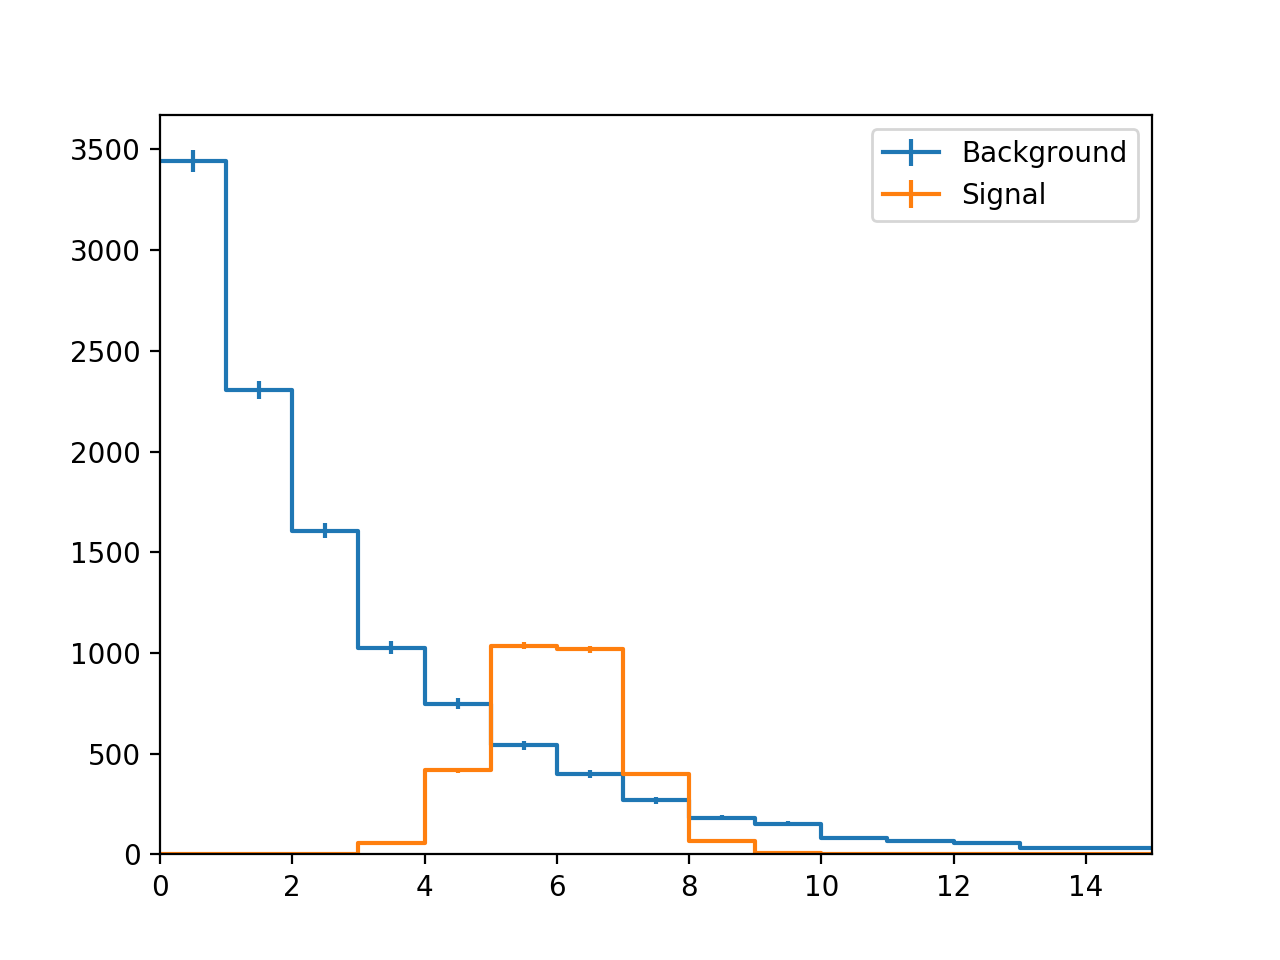

In [3]:
fig, ax = plt.subplots()

# Usually sumw2 would be part of the histogram filling package
sumw2_bkg = pdf_bkg1*weight_bkg1 + pdf_bkg2*weight_bkg2
sumw2_sig = pdf_signal*weight_signal

bin_centers = (bin_edges[:-1] + bin_edges[1:])/2

ax.errorbar(x=np.r_[bin_edges[0], bin_centers, bin_edges[-1]],
            y=np.r_[sum_bkg[0], sum_bkg, sum_bkg[-1]],
            yerr=np.r_[0, np.sqrt(sumw2_bkg), 0],
            label='Background', drawstyle='steps-mid'
           )

ax.errorbar(x=np.r_[bin_edges[0], bin_centers, bin_edges[-1]],
            y=np.r_[pdf_signal[0], pdf_signal, pdf_signal[-1]],
            yerr=np.r_[0, np.sqrt(sumw2_sig), 0],
            label='Signal', drawstyle='steps-mid'
           )

ax.autoscale(axis='x', tight=True)
ax.set_ylim(0, None)
ax.legend()

## Stack plot


<IPython.core.display.Javascript object>


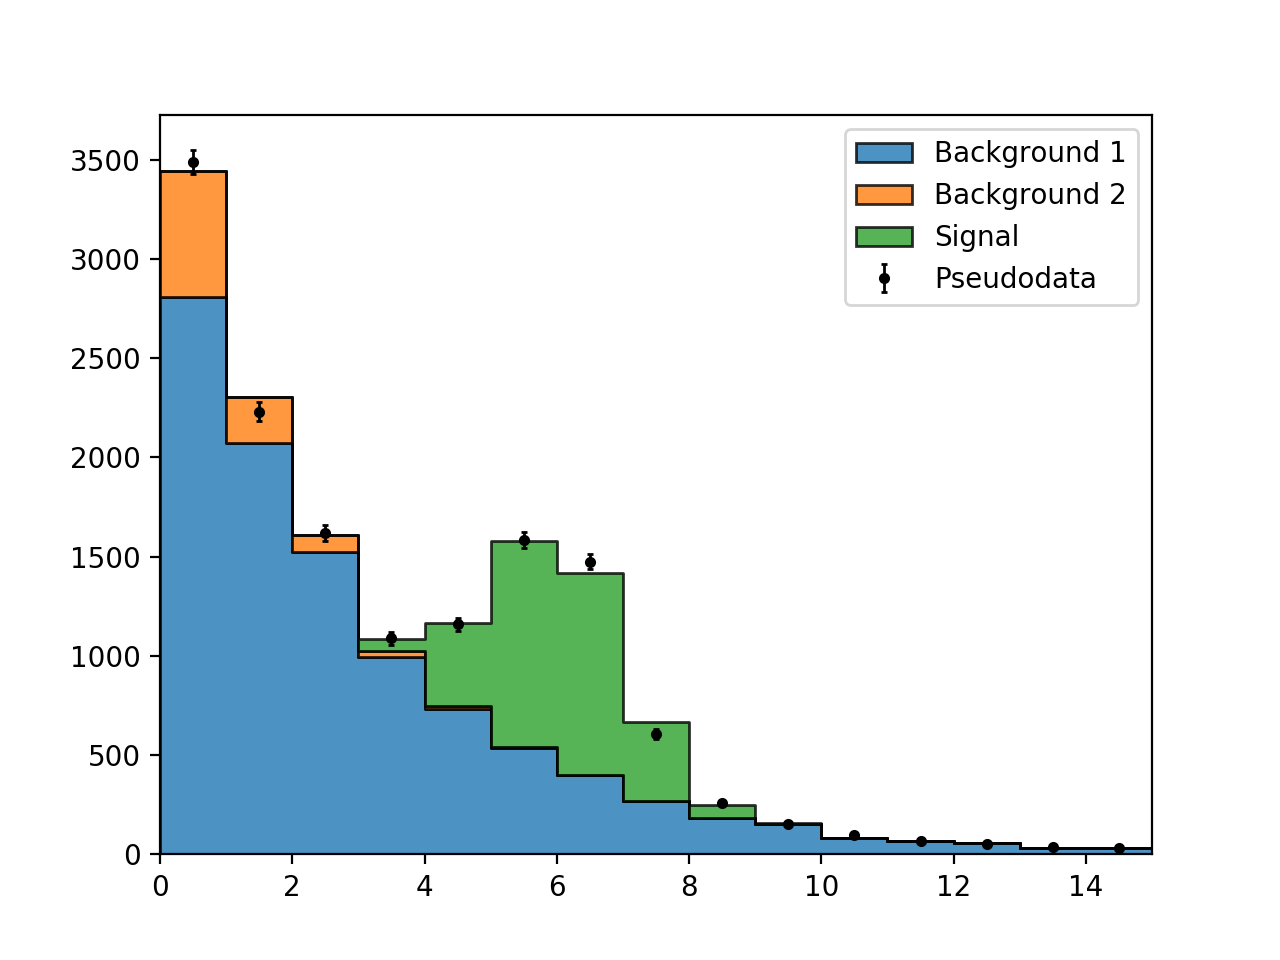

In [4]:
fig, ax = plt.subplots()

fill_opts = {
    'edgecolor': (0, 0, 0, 0.1),
    'alpha': 0.8
}

labels = ['Background 1', 'Background 2', 'Signal']

cumulative = np.zeros_like(pdf_bkg1)
for i,source in enumerate([pdf_bkg1, pdf_bkg2, pdf_signal]):
    ax.fill_between(x=bin_edges,
                    y1=np.r_[cumulative, 0],
                    y2=np.r_[cumulative+source, 0],
                    label=labels[i],
                    step='post', **fill_opts)
    cumulative += source

    
ax.errorbar(x=bin_centers,
            y=observed_pdf,
            yerr=np.sqrt(observed_pdf),
            linestyle='none', marker='.', elinewidth=1, capsize=1, color='k',
            label='Pseudodata'
           )

# if low counts, can use Garwood intervals:
# elo = scipy.stats.chi2.ppf((1 - coverage)/2, 2*counts)/2.
# ehi = scipy.stats.chi2.ppf((1 + coverage)/2, 2*(counts + 1))/2.

ax.autoscale(axis='x', tight=True)
ax.set_ylim(0, None)
ax.legend()